In [1]:
import os
%matplotlib inline

import cobra
import cobra.io
from cobra import Model, Reaction, Metabolite
from cobra.io.sbml import create_cobra_model_from_sbml_file
from cobra.io.sbml import write_cobra_model_to_sbml_file
from cobra.io.mat import load_matlab_model
from cobra.io.mat import save_matlab_model
from scipy.io import loadmat, savemat

from cobra.flux_analysis import variability

# Panda python module for dataframe and data storage/manipulation
import pandas as pd
pd.set_option('mode.use_inf_as_null',True)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 999)
pd.set_option('precision', 3)

import seaborn as sns
sns.set(style="white")
c1, c2, c3, c4, c5, c6, c7, c8, c9, c10 = sns.color_palette("Set2", 10)
b1, b2, b3, b4, b5, b6 = sns.color_palette("Blues")

from contextlib import contextmanager
import sys, os
 
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

from copy import deepcopy
import scipy.io
import scipy.sparse as sparse
import random as rand
print "I'm using scipy version:" 
scipy.__version__

I'm using scipy version:


'0.14.0'

In [2]:
ROOT_DIR = os.getcwd()
!pwd

/media/ebrunk/LACIE/Projects/GIT_HUB/Scripts


### Download model (e coli core model)

In [3]:
!wget http://bigg.ucsd.edu/static/models/e_coli_core.mat

--2016-08-16 20:10:48--  http://bigg.ucsd.edu/static/models/e_coli_core.mat
Resolving bigg.ucsd.edu (bigg.ucsd.edu)... 132.239.8.55
Connecting to bigg.ucsd.edu (bigg.ucsd.edu)|132.239.8.55|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63744 (62K) [application/octet-stream]
Saving to: ‘e_coli_core.mat’

100%[======================================>] 63,744      --.-K/s   in 0s      

2016-08-16 20:10:48 (139 MB/s) - ‘e_coli_core.mat’ saved [63744/63744]



In [4]:
!ls e_coli_core*

e_coli_core.mat  e_coli_core.xml


### Load in model

In [5]:
ecoli_mat = ROOT_DIR + '/e_coli_core.mat'
m = load_matlab_model(ecoli_mat)

### Run FBA

In [6]:
m.optimize()

<Solution 0.873921506968 at 0x7f7f45057690>

In [7]:
m.solution.f

0.8739215069684305

In [8]:
m.solution.status

'optimal'

### Change objective function

In [9]:
m.reactions.ATPM.objective_coefficient = 1
m.reactions.BIOMASS_Ecoli_core_w_GAM.objective_coefficient = 0

m.optimize()

<Solution 175.0 at 0x7f7f18573690>

In [10]:
m.reactions.ATPM.objective_coefficient = 0
m.reactions.BIOMASS_Ecoli_core_w_GAM.objective_coefficient = 1

m.optimize()

<Solution 0.873921506968 at 0x7f7f45057650>

### Adding / Deleting Reactions

#### example: remove etoh transport

In [12]:
print "reactants:", [i.id for i in m.reactions.EX_etoh_e.get_reactants()]
print "products:", [i.id for i in m.reactions.EX_etoh_e.get_products()]
print "coefficients:", m.reactions.EX_etoh_e.metabolites
print "lower bound:", m.reactions.EX_etoh_e.lower_bound
print "upper bound:", m.reactions.EX_etoh_e.upper_bound

reactants: ['etoh_e']
products: []
coefficients: {<Metabolite etoh_e at 0x7f7f18bfd8d0>: -1.0}
lower bound: 0.0
upper bound: 1000.0


#### remove reaction

In [13]:
m.remove_reactions('EX_etoh_e')

#### add it back to the model

In [14]:
from cobra import Model, Reaction, Metabolite

reaction = Reaction('EX_etoh_e')
reaction.name = 'ETOH exchange reaction'
reaction.subsystem = 'Exchange'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.objective_coefficient = 0. # this is the default

In [15]:
reaction.add_metabolites({m.metabolites.etoh_e: -1.0})

In [16]:
reaction.reaction

'etoh_e --> '

In [17]:
m.add_reaction(reaction)

#### check that its back in the model

In [18]:
print "reactants:", [i.id for i in m.reactions.EX_etoh_e.get_reactants()]
print "products:", [i.id for i in m.reactions.EX_etoh_e.get_products()]
print "coefficients:", m.reactions.EX_etoh_e.metabolites
print "lower bound:", m.reactions.EX_etoh_e.lower_bound
print "upper bound:", m.reactions.EX_etoh_e.upper_bound

reactants: ['etoh_e']
products: []
coefficients: {<Metabolite etoh_e at 0x7f7f18bfd8d0>: -1.0}
lower bound: 0.0
upper bound: 1000.0


### Flux Variability Analysis (FVA)

In [19]:
from cobra.flux_analysis.variability import flux_variability_analysis
opt_fract = 0.9

flux_var = flux_variability_analysis(m, allow_loops=False, fraction_of_optimum=opt_fract)

#### Finds all reaction fluxes whose minimum and maximum flux differs by 20 (mmol/gDW*hr)

In [20]:
read_to_struct = [] 
for r in m.reactions:
    if flux_var[r.id]['maximum'] - flux_var[r.id]['minimum'] > 20:
        read_to_struct.append({'rxn':r.id, 'min':flux_var[r.id]['minimum'], 'max':flux_var[r.id]['maximum']})

pd.DataFrame(read_to_struct).set_index('rxn')

,max,min
rxn,,
ATPS4r,59.38,3.48e+01
FORt2,68.64,0.00e+00
FORti,68.64,0.00e+00
FRD7,1000.00,0.00e+00
G6PDH2r,24.14,0.00e+00
GND,24.14,0.00e+00
NADTRHD,44.76,0.00e+00
PFK,25.29,1.17e+00
PGI,9.84,-1.43e+01


### Exercise: Change glucose uptake rate and solve FBA

In [21]:
print m.reactions.EX_glc__D_e.upper_bound
print m.reactions.EX_glc__D_e.lower_bound

1000.0
-10.0


In [22]:
val = [-10, -8, -7, -6, -5, -4, -3, -2, -1]

read_to_struct = []

for i in val:
    m.reactions.EX_glc__D_e.upper_bound = 0
    m.reactions.EX_glc__D_e.lower_bound = i
    m.reactions.BIOMASS_Ecoli_core_w_GAM.objective_coefficient = 1
    sol = m.optimize()
    
    read_to_struct.append({'glc_uptake':i, 'sol':sol})
DF_glc_uptake = pd.DataFrame(read_to_struct)
DF_glc_uptake

,glc_uptake,sol
0,-10,0.873921506968
1,-8,0.690592014218
2,-7,0.598927267843
3,-6,0.507262521468
4,-5,0.415597775093
5,-4,0.323933028718
6,-3,0.232268282343
7,-2,0.140603535968
8,-1,0.0483849722968


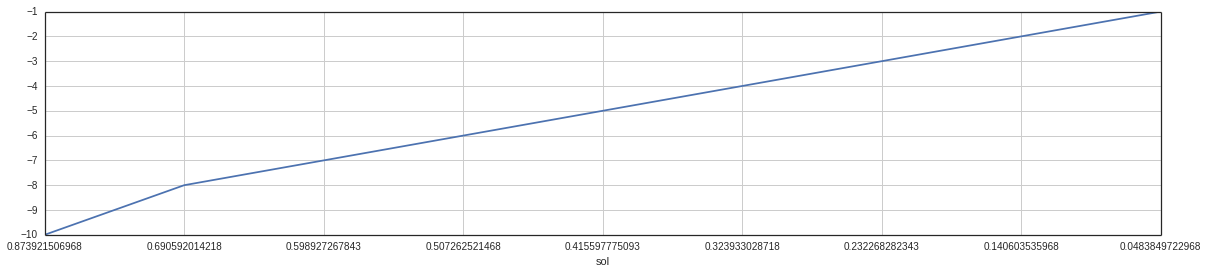

In [23]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(20,4))

df = DF_glc_uptake#.set_index('glc_uptake')
df.plot(x='sol', y='glc_uptake', ax=ax)